stream DM density:  3.0805198277639875e-43
local density:  0.02812765329247661 solMass / pc3
soving...
mass:  2.86130531112309  x 10^11 Msun, radius:  135.928253427261  kpc
(1000000,)
(1000000,)
(1000000,)
(1000000,)
(1000000,)
(1000000,)


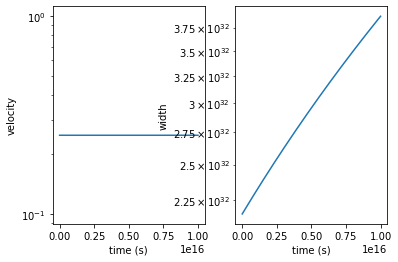

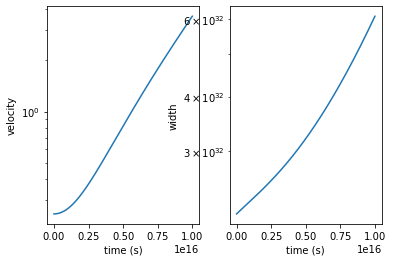

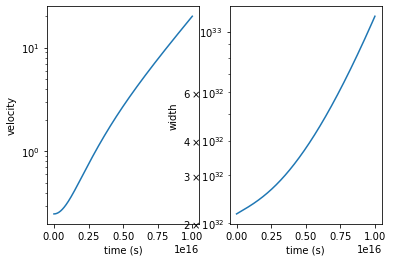

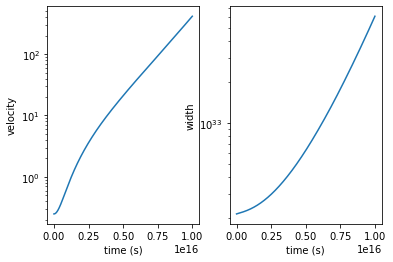

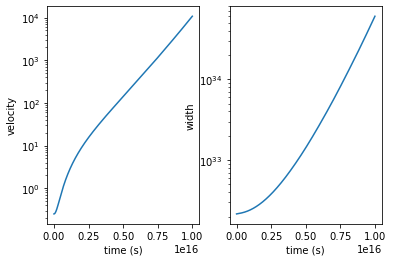

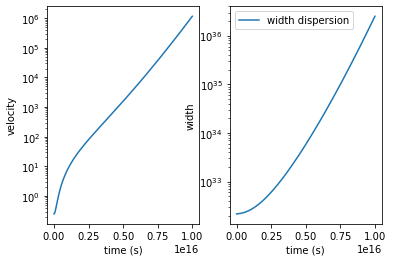

In [30]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.integrate import solve_ivp 
import astropy.units as un
import astropy.constants as cnst
import profile as pf

## additional imports
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7) 

import sympy
from sympy import symbols


rho_crit = 3 * cosmo.H(0)**2 / (8 * np.pi * cnst.G)

class NFWProfile():
    def __init__(self, r_s, rho_s):
        self.r_s = r_s
        self.rho_s = rho_s # properly define this, should I use rho_0?
       
        self.M = None
        self.mass_profile = None

        self.potential_profile = None

        # self.c = 10 # 10 to 15 for mw via wikipedia, concentration parameter
        # self.R_vir = None # R_vir = c * r_s 
        # self.r_max = None

        self.r_200 = None
        self.m_200 = None

    def density(self, r):
        return self.rho_s / ((r / self.r_s)**1 * (1 + (r / self.r_s))**(3 - 1))

    def mass(self, r = None, set = False):
        if r == None:
            if self.r_200 != None:
                r = self.r_200
            else:
                self.set_200()
                r = self.r_200
        if set:
            self.mass_profile = 4 * np.pi * self.rho_s * self.r_s**3 * (np.log((self.r_s + r) / self.r_s)  + (self.r_s / (self.r_s + r) - 1))
        else:
            return 4 * np.pi * self.rho_s * self.r_s**3 * (np.log((self.r_s + r)/self.r_s)  + (self.r_s/(self.r_s + r) - 1))

    def r_when(self, rho): # TODO
        r= symbols('r', real = True)
        expr = (self.rho_s / rho).value / ((r) * (1 + (r ))**(2)) # ((sympy.sqrt(r)*(1 + r**2)) / sympy.sqrt((self.rho_s / rho).value))
        print('soving...')
        rr_s = sympy.solve(sympy.Eq(expr, 1), r)
        # print('ratio of r/r_s: ', rr_s) # rr_s = r / self.r_s
        return rr_s * self.r_s
        
    def set_200(self):
        rho_crit = (3 * cosmo.H(0)**2 / (8 * np.pi * cnst.G)).to(un.Msun / un.pc**3)
        self.r_200 = self.r_when(200 * rho_crit).to(un.kpc)
        self.m_200 = (100 * self.r_200**3 * cosmo.H(0)**2 / cnst.G).to(un.Msun)

    def potential(self, r, set = False):
        if set:
            self.potential_profile = ((4 * np.pi * cnst.G * self.rho_s * self.r_s**3) / r) * np.log(1 + (r / self.r_s))
        else:
            return ((4 * np.pi * cnst.G * self.rho_s * self.r_s**3) / r) * np.log(1 + (r / self.r_s))
    
    

# Defining the ODEs 
G= 1.325*10**11
k = 1 
f_DM = np.linspace(0,1,3)
r_s   = 8.9  * un.kpc # 8.8 , 8.1 Pal5/Schonrich2010
m     = 6E11 * un.Msun
rho_s = 0.11 * un.Msun / (un.pc)**3 # 0.11
r     = np.logspace(-3, 1.5, 256) * un.kpc
# prop = pf.McMillanProfile(r_s = 15 * un.kpc, rho_s = 0.011 * un.Msun / (un.pc)**3 )
nfwp  = NFWProfile(r_s = r_s, rho_s = rho_s)
r = 15 * un.kpc
rho = nfwp.density(r).to(un.Msun / (un.km)**3).value # cant be greater than 0.02 for around sun
print('stream DM density: ', rho)
print('local density: ', nfwp.density(8.8 * un.kpc))
nfwp.set_200()
print('mass: ', (nfwp.m_200 / 10**11).value[0], ' x 10^11 Msun, radius: ',  nfwp.r_200.value[0], ' kpc')
t = np.linspace(0, 3*10**16, int(10E6)) # * un.Gyr cnst.G
t = np.linspace(0, 1e16, int(1e6)) # * un.Gyr cnst.G

GG = cnst.G.to(un.pc**3 / (un.Msun * un.yr**2))

def f(t, y): 
    #velSq = y[0]
    #widthSq = y[1]
    #make sure input and output units match 
    # unless t and width can beat out truncation error VVV this wont work
    X = np.zeros(2)
    X[0] = ((2*np.pi*G*k*rho*g)**2* t * y[1]) # look into  units
    
    # should vel be delta vel?
    X[1] = (2 * np.sqrt(y[0] * y[1])) # look into units 

    return X


for g in [.0,.05,.1, 0.25,0.5,1]:
    sol = solve_ivp(f, [0, 1e16], [0.25,2.16e32], t_eval = t)
    velocity = sol.y[0]
    width = sol.y[1]
    
    tt = sol.t
    print(np.shape(tt))
    #print('vel',velocity)

    fig, ax = plt.subplots(1, 2)
    ax1, ax2 = ax[0], ax[1]

    #ax1.semilogy((tt * un.yr).to(un.Gyr), velocity, label = 'velocity dispersion ')
    ax1.semilogy(tt, velocity, label = 'velocity dispersion ')
    #ax1.set_xscale('log')
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('velocity')

    ax2.semilogy(tt, width, label = 'width dispersion')
    ax2.set_xlabel('time (s)')
    ax2.set_ylabel('width')

plt.legend()
plt.show()